In [1]:
import numpy as np
import tensorflow as tf
import pyreadr
import pandas as pd
import keras
from keras.layers import Dense,Dropout,BatchNormalization
from keras.models import Sequential,Model
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from sklearn.covariance import MinCovDet,EmpiricalCovariance
from matplotlib.pyplot import hist
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
# Set seeds for random number generators for reproducable results
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)

In [4]:
# Load training data
data = pyreadr.read_r("/home/shanmukh/Documents/IICT/tep-fault-detection/dataset/TEP_FaultFree_Training.RData")
df = data['fault_free_training']
training_data = df.drop(["faultNumber","simulationRun","sample"],axis=1)

In [5]:
# Standard Normalization
# 0 mean 
# 1 std
scaler = StandardScaler()
scaler.fit(training_data)
training_data = scaler.transform(training_data)

In [6]:
model = load_model("/home/shanmukh/Documents/IICT/tep-fault-detection/models/weights-55-0.09.hdf5")
encoder = Model(inputs=model.input,outputs=model.get_layer('latent_space').output)
    # model.summary()
    # encoder.summary()

In [7]:
# Get outputs
predictions = model.predict(training_data,batch_size=512)
latent = encoder.predict(training_data,batch_size=512)
# Set Percentile Tresholds
percentile_treshold = 95

8.317551184141351


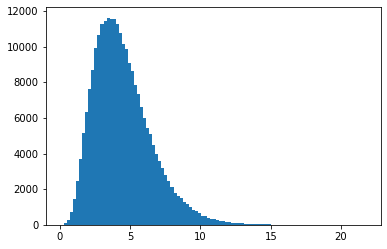

In [16]:
# SPE statistic
spe = np.sum((training_data - predictions)**2,axis=1)
cutoff_spe = np.percentile(spe,percentile_treshold)
np.savetxt("spe_train.dat",spe)
_ = hist(spe,bins=100)
print (cutoff_spe)

46.18094748901319


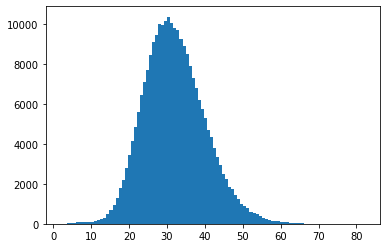

In [15]:
# Mahalanobis distance
cov = EmpiricalCovariance().fit(latent)
md = cov.mahalanobis(latent)
cutoff_md = np.percentile(md,percentile_treshold)
_ = hist(md,bins=100)
np.savetxt("T2_train.dat",md)
print (cutoff_md)

1.7770198359405076


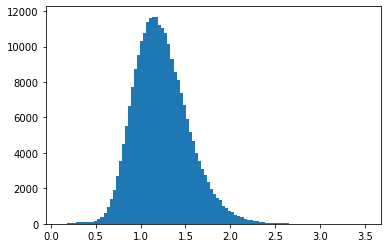

In [17]:
# Unified Index
ui = spe/cutoff_spe + md/cutoff_md
cutoff_ui = np.percentile(ui,percentile_treshold)
_ = hist(ui,bins=100)
print (cutoff_ui)
np.savetxt("Unified_index_train.dat",ui)

In [11]:
# Hotelling's T^2 Statistic
# covariance = cov.covariance_
# # pseudo inverse
# inv = np.linalg.pinv(covariance)
# t2 = [np.matmul(np.matmul(np.matrix(i),np.matrix(inv)),np.matrix(i).T) for i in latent]
# t2 = np.array(t2).squeeze()

In [12]:
# Load and normalize Testing Data
test_files = []
for i in range(22):
    test_files.append('d'+format(i, '02d')+"_te.dat")
path_to_test = "/home/shanmukh/Documents/IICT/tep-fault-detection/dataset/TE_process/"
test_data = []
test_data_normalized = []
for i in test_files:
    test_data.append(np.loadtxt(path_to_test+i))
    test_data_normalized.append(scaler.transform(test_data[-1]))
truth = np.ones(shape = (800,))

In [23]:
# Metrics
spe_all = []
md_all = []
ui_all = []
missed_detection_rates = []
x = np.array(list(range(960)))
temp = 0
for i in test_data_normalized:
    predictions_test = model.predict(i,batch_size=480)
    latent_test = encoder.predict(i,batch_size=480)
    spe_test = np.sum((i - predictions_test)**2,axis=1)
    md_test = cov.mahalanobis(latent_test)
    ui_test = spe_test/cutoff_spe + md_test/cutoff_md
    spe_y = np.zeros_like(spe_test)
    spe_y[spe_test>cutoff_spe] = 1 
    md_y = np.zeros_like(md_test)
    md_y[md_test>cutoff_md] = 1
    ui_y = np.zeros_like(ui_test)
    ui_y[ui_test>cutoff_ui] = 1
    np.savetxt("indices/spe_"+test_files[temp],spe_test)
    np.savetxt("indices/T2_"+test_files[temp],md_test)
    np.savetxt("indices/Unified_"+test_files[temp],ui_test)
#     plt.plot(x,spe_test)
    print (temp,",",1-accuracy_score(spe_y[160:],truth),",",1-accuracy_score(md_y[160:],truth),",",1-accuracy_score(ui_y[160:],truth))
    missed_detection_rates.append(1-accuracy_score(ui_y[160:],truth))
    temp+=1
    

0 , 0.94125 , 0.93125 , 0.9299999999999999
1 , 0.0024999999999999467 , 0.0050000000000000044 , 0.0024999999999999467
2 , 0.015000000000000013 , 0.012499999999999956 , 0.01375000000000004
3 , 0.94375 , 0.93625 , 0.93125
4 , 0.0 , 0.35624999999999996 , 0.0
5 , 0.63625 , 0.70375 , 0.6
6 , 0.0 , 0.010000000000000009 , 0.0
7 , 0.0 , 0.0 , 0.0
8 , 0.02375000000000005 , 0.02375000000000005 , 0.01749999999999996
9 , 0.94 , 0.935 , 0.92625
10 , 0.47750000000000004 , 0.5900000000000001 , 0.39
11 , 0.30374999999999996 , 0.385 , 0.17500000000000004
12 , 0.03500000000000003 , 0.011249999999999982 , 0.008750000000000036
13 , 0.04500000000000004 , 0.04749999999999999 , 0.04500000000000004
14 , 0.0012499999999999734 , 0.0012499999999999734 , 0.0
15 , 0.94125 , 0.925 , 0.915
16 , 0.51125 , 0.76125 , 0.4675
17 , 0.036250000000000004 , 0.1725 , 0.040000000000000036
18 , 0.09499999999999997 , 0.09999999999999998 , 0.09375
19 , 0.7462500000000001 , 0.78625 , 0.6675
20 , 0.39749999999999996 , 0.6275 , 0.36


In [14]:
np.mean(missed_detection_rates[1:])

0.29238095238095235

In [21]:
x

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18